In [1]:
import os, torch, torchvision, pandas, pickle
import numpy as np

from torch import nn
from torchvision.models import feature_extraction
from torch.utils.data import Dataset, DataLoader

#ridge regression
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GroupKFold

import sys
sys.path.append('/home/maellef/git/cNeuromod_encoding_2020')
from models import encoding_models as encod

#visualisation
from matplotlib import pyplot as plt
from matplotlib import colors, colormaps
#brain visualization import
from nilearn import regions, datasets, surface, plotting, image, maskers
from nilearn.plotting import plot_roi, plot_stat_map
MIST_path = '/home/maellef/DataBase/fMRI_parcellations/MIST_parcellation/Parcellations/MIST_ROI.nii.gz'

In [2]:
def surface_fig(parcel_data, vmax, threshold=0, cmap='turbo', inflate=True, colorbar=True, 
                no_background=True, symmetric_cbar=True):     
    nii_data = regions.signals_to_img_labels(parcel_data, MIST_path)
    fig, ax = plotting.plot_img_on_surf(nii_data,
                              views=['lateral', 'medial'], hemispheres=['left', 'right'], inflate=inflate,
                              vmax=vmax, threshold=threshold, colorbar=colorbar, cmap=cmap, 
                                        symmetric_cbar=symmetric_cbar, cbar_tick_format="%.1f")
    return fig

In [3]:
def extend_colormap(original_colormap = 'twilight', percent_start = 0.25, percent_finish = 0.25):
    colormap = colormaps[original_colormap]
    nb_colors = colormap.N
    new_colors_range = colormap(np.linspace(0,1,nb_colors))

    n_start = round(nb_colors/(1-percent_start)) - nb_colors if percent_start != 0 else 0
    new_color_start = np.array([colormap(0)]*n_start).reshape(-1, new_colors_range.shape[1])
    n_finish = round(nb_colors/(1-percent_finish)) - nb_colors if percent_finish != 0 else 0
    new_color_finish = np.array([colormap(0)]*n_finish).reshape(-1, new_colors_range.shape[1])

    new_colors_range = np.concatenate((new_color_start,new_colors_range,new_color_finish), axis=0)
    new_colormap = colors.ListedColormap(new_colors_range)
    return new_colormap

In [4]:
def load_sub_models(sub, scale, conv, models_path, no_init=False): 
    models = {}
    #scale_path = os.path.join(models_path, sub, scale)
    for model in os.listdir(models_path):
        if '.pt' in model and conv in model and sub in model and scale in model:
            model_path = os.path.join(models_path, model)
            modeldict = torch.load(model_path, map_location=torch.device('cpu'))
            model_net = encod.SoundNetEncoding_conv(out_size=modeldict['out_size'],output_layer=modeldict['output_layer'],
                                                    kernel_size=modeldict['kernel_size'], no_init=no_init)
            if not no_init:
                model_net.load_state_dict(modeldict['checkpoint'])
            models[model] = model_net
    return models

In [5]:
class mutemusic_dataset(Dataset):
    def __init__(self, data):
        self.x = [x for (x, y) in data]
        self.y = [y for (x, y) in data]
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [6]:
def test(dataloader, net, epoch, mseloss, return_nodes, gpu=True):
    net.eval()
    out_p = {layer_name:[] for layer_name in return_nodes.values()}
    
    with torch.no_grad():
        for (x,y) in dataloader:
            #print(x.shape, y.shape)
            # load data
            x = torch.Tensor(x).view(1,1,-1,1)
            # Forward pass
            y_p = net(x, epoch)
            
            for key, p in y_p.items():
                #print(val.shape)
                p = p.permute(2,1,0,3).squeeze()
                #print(p.shape, y.shape)
                out_p[key].append((p.numpy(), y.numpy()))
    return out_p

In [7]:
#necessary args
sub = 'sub-03'
no_init = False
conv = 'conv4' #'opt110_wb'#, 'sub-02', 'sub-03', 'sub-04', 'sub-05'
scale = 'MIST_ROI'#, 'auditory_Voxels' 
shape = 210

#load and extract model from dict
models_path = '/home/maellef/Results/best_models/converted' 
models = load_sub_models(sub, scale, conv, models_path, no_init=no_init)
for name, model in models.items():
    pass

#load data + metadata
data_df = pandas.read_csv(f'{sub}_metadata.tsv', sep='\t')
with open(f'{sub}_pairWavBold', 'rb') as f: 
    wavbold = pickle.load(f)

shape of encoding matrice from last encoding layer : 1024 X 210


In [8]:
#extract X and Y data for prediction + check for empty data (WIP: move to previous later)
empty_pair = []
for i, (wav, bold) in enumerate(wavbold):
    if wav.shape[0] == 0 and bold.shape[0] == 0:
        empty_pair.append(i)

correct_wavbold = [(wav, bold) for (wav, bold) in wavbold if wav.shape[0] != 0]

In [9]:
#define all possible output (WIP) + create model with extractable embeddings
train_nodes, eval_nodes = feature_extraction.get_graph_node_names(model)
#return_nodes = {layer:layer[len('soundnet.'):-2] for layer in train_nodes if layer[-1] == '2'}
print(eval_nodes)

return_nodes = {'soundnet.conv7.2':'conv7'}
print(return_nodes)
model_feat = feature_extraction.create_feature_extractor(model, return_nodes=return_nodes)

['x', 'epoch', 'soundnet.conv1.0', 'soundnet.conv1.1', 'soundnet.conv1.2', 'soundnet.pool1', 'soundnet.conv2.0', 'soundnet.conv2.1', 'soundnet.conv2.2', 'soundnet.pool2', 'soundnet.conv3.0', 'soundnet.conv3.1', 'soundnet.conv3.2', 'soundnet.conv4.0', 'soundnet.conv4.1', 'soundnet.conv4.2', 'soundnet.conv5.0', 'soundnet.conv5.1', 'soundnet.conv5.2', 'soundnet.pool5', 'soundnet.conv6.0', 'soundnet.conv6.1', 'soundnet.conv6.2', 'soundnet.conv7.0', 'soundnet.conv7.1', 'soundnet.conv7.2', 'encoding_fmri']
{'soundnet.conv7.2': 'conv7'}


In [10]:
#create dataset for dataloader
dataset = mutemusic_dataset(correct_wavbold)
testloader = DataLoader(dataset)

In [11]:
#extract embedding from selected model
out_p = test(testloader, net=model_feat, epoch=1, 
     mseloss=nn.MSELoss(reduction='sum'), 
     return_nodes=return_nodes, gpu=False)

In [12]:
print(out_p['conv7'][0][0].shape)
print(out_p['conv7'][0][1].shape)

(31, 1024)
(1, 30, 210)


In [13]:
#select data depending on metadata infos
correct_data_df = data_df.drop(empty_pair).reset_index()
correct_data_df.drop(['index', 'Unnamed: 0'], axis='columns', inplace=True)

music_index = correct_data_df[correct_data_df['stimuli']=='m'].index
silence_index = correct_data_df[correct_data_df['stimuli']=='s'].index

music_data = [(p, y.squeeze()) for i, (p, y) in enumerate(out_p['conv7']) if i in music_index]
silence_data = [(p, y.squeeze()) for i, (p, y) in enumerate(out_p['conv7']) if i in silence_index]

In [14]:
#compile all selected data in seperate x/y arrays
music_Xarray = np.array([]).reshape(-1, 1024)
silence_Xarray = np.array([]).reshape(-1, 1024)
music_Yarray = np.array([]).reshape(-1, 210)
silence_Yarray = np.array([]).reshape(-1, 210)

for i, (musicX, musicY) in enumerate(music_data):
    #a few bold segments seem to have no data ? to check
    if musicX.ndim > 1 and musicY.ndim > 1:  
        nbtr = musicY.shape[0]
        music_Xarray = np.concatenate([music_Xarray, musicX[:nbtr, :]])
        music_Yarray = np.concatenate([music_Yarray, musicY])        

for i, (silenceX, silenceY) in enumerate(silence_data):
    #a few bold segments seem to have no data ? to check
    if silenceX.ndim > 1 and silenceY.ndim > 1:  
        nbtr = silenceY.shape[0]
        silence_Xarray = np.concatenate([silence_Xarray, silenceX[:nbtr, :]])
        silence_Yarray = np.concatenate([silence_Yarray, silenceY])

print(music_Xarray.shape, music_Yarray.shape)
print(silence_Xarray.shape, silence_Yarray.shape)

(5109, 1024) (5109, 210)
(1428, 1024) (1428, 210)


In [15]:
#define train/val/test --> train music / test silence
train_x = music_Xarray
train_y = music_Yarray

test_x = silence_Xarray
test_y = silence_Yarray

In [ ]:
#define train/val/test --> train music / test music / silence
len_test = int(music_Xarray.shape[0]*0.2)
len_train = music_Xarray.shape[0] -  len_test
print(len_train, len_test)

train_x = music_Xarray[:len_train]
train_y = music_Yarray[:len_train]

test_mus_x = music_Xarray[len_train:]
test_mus_y = music_Yarray[len_train:]

test_sil_x = silence_Xarray[:len_test]
test_sil_y = silence_Yarray[:len_test]

In [16]:
#define train/val/test --> train silence / test music / silence
len_test = int(silence_Xarray.shape[0]*0.2)
len_train = silence_Xarray.shape[0] -  len_test
print(len_train, len_test)

train_x = silence_Xarray[:len_train]
train_y = silence_Yarray[:len_train]

test_sil_x = silence_Xarray[len_train:]
test_sil_y = silence_Yarray[len_train:]

test_mus_x = music_Xarray[:len_test]
test_mus_y = music_Yarray[:len_test]


1143 285


In [17]:
alphas = np.logspace(0.1, 3, 10)
model = RidgeCV(
        alphas=alphas,
        fit_intercept=True,
        cv=10)

model.fit(train_x, train_y)

RidgeCV(alphas=array([   1.25892541,    2.64376119,    5.55193591,   11.65914401,
         24.48436747,   51.41751828,  107.97751623,  226.75431259,
        476.1872663 , 1000.        ]),
        cv=10)

0.46655214422355085


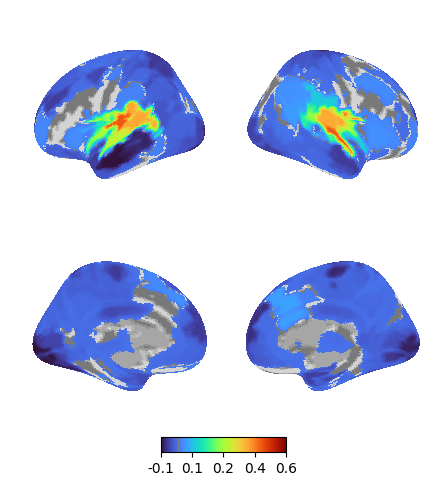

In [24]:
y_pmus = model.predict(test_mus_x)
r2 = r2_score(test_mus_y, y_pmus, multioutput='raw_values')
print(max(r2))
colormap = extend_colormap(original_colormap='turbo',
                          percent_start = 0.1, percent_finish=0)
surface_fig(r2, vmax=0.6, threshold=0.005, cmap='turbo', symmetric_cbar=False)

savepath = f'./figures/{sub}_train_silence_predict_music_3.png'
plt.savefig(savepath)

0.47536306008634355


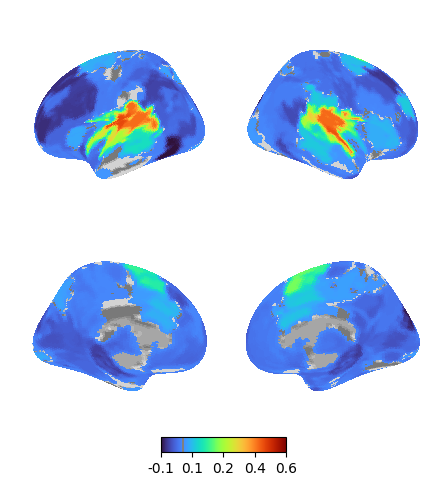

In [20]:
y_psil = model.predict(test_sil_x)
r2 = r2_score(test_sil_y, y_psil, multioutput='raw_values')
print(max(r2))
colormap = extend_colormap(original_colormap='turbo',
                          percent_start = 0.1, percent_finish=0)
surface_fig(r2, vmax=0.6, threshold=0.005, cmap='turbo', symmetric_cbar=False) #'gist_stern_r'

savepath = f'./figures/{sub}_train_silence_predict_silence_3turbo.png'
plt.savefig(savepath)

In [23]:
MISTinfo_path = '/home/maellef/DataBase/fMRI_parcellations/MIST_parcellation/Parcel_Information/MIST_ROI.csv'
MIST_df = pandas.read_csv(MISTinfo_path, sep=';')

min = []
imin = []
for i in range(len(r2)):
    if r2[i] < -2:
        min.append(r2[i])
        imin.append(i)
print(imin, min)
print(MIST_df.iloc[imin]['name'])
print(MIST_df.iloc[48]['name'])
print(r2[48])
print(MIST_df.iloc[49]['name'])
print(r2[49])
print(MIST_df.iloc[208]['name'])
print(r2[208])
print(MIST_df.iloc[209]['name'])
print(r2[209])

[] []
Series([], Name: name, dtype: object)
right_PRE_SUPPLEMENTARY_MOTOR_CORTEX_posterior
0.1468005481984196
left_PRE_SUPPLEMENTARY_MOTOR_CORTEX_posterior
0.1467380025965762
left_PRE_SUPPLEMENTARY_MOTOR_CORTEX_anterior
0.12960907193361815
right_PRE_SUPPLEMENTARY_MOTOR_CORTEX_anterior
0.1963013462956329
